# Figure 6

In [1]:
from sympy import symbols, exp, solve, logcombine, simplify, Piecewise, lambdify, N, init_printing, Eq
import numpy
import scipy.stats as ss
from sympy.physics.units import seconds, siemens, volts, farads, amperes, milli, micro, nano, pico, ms, s, kg, meters
from matplotlib import pyplot as plt
import matplotlib
plt.style.use('neuron_color')
import os
import sys
sys.path.append('../')
from Linearity import Neuron
import lmfit
from pickle import dump

In [2]:
def simpleaxis(axes, every=False, outward=False):
    if not isinstance(axes, (list, numpy.ndarray)):
        axes = [axes]
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if (outward):
            ax.spines['bottom'].set_position(('outward', 10))
            ax.spines['left'].set_position(('outward', 10))
        if every:
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_title('')

In [3]:
from IPython.display import display, Markdown, Image

In [4]:
init_printing()

## 6 A Circuit diagram

<img src="Fig_6_a.png" alt="Drawing" style="width: 800px;"/>

## 6 B: Fitting voltage clamp data to get parameters

In [5]:
analysisFile = '/media/sahil/NCBS_Shares_BGStim/patch_data/170530/c1_EI/plots/c1_EI.pkl'
plotDir = os.path.dirname(analysisFile)
neuron = Neuron.load(analysisFile)

$g(t) = \bar{g}\frac{( e^\frac{\delta_{onset} - t }{\tau_{decay}} - e^\frac{\delta_{onset} - t }{\tau_{rise}})}{- \left(\frac{\tau_{rise}}{\tau_{decay}}\right)^{\frac{\tau_{decay}}{\tau_{decay} - \tau_{rise}}} + \left(\frac{\tau_{rise}}{\tau_{decay}}\right)^{\frac{\tau_{rise}}{\tau_{decay} - \tau_{rise}}}}$

In [25]:
def fitFunctionToPSP(time, vector, t_0=0, g_max=0):
    ''' Fits using lmfit '''

    def _doubleExponentialFunction(t, t_0, tOn, tOff, g_max):
        ''' Returns the shape of an EPSP as a double exponential function '''
        tPeak = t_0 + float(((tOff * tOn)/(tOff-tOn)) * numpy.log(tOff/tOn))
        A = 1./(numpy.exp(-(tPeak-t_0)/tOff) - numpy.exp(-(tPeak-t_0)/tOn))
        g = [ g_max * A * (numpy.exp(-(t_point-t_0)/tOff) - numpy.exp(-(t_point-t_0)/tOn)) if  t_point >= t_0 else 0. for t_point in t]
        return numpy.array(g)

    model = lmfit.Model(_doubleExponentialFunction)
    # Fixing values of variables from data
    # Onset time
    if not t_0:
        model.set_param_hint('t_0', value =max(time)/10., min=0., max = max(time))
    else:
        model.set_param_hint('t_0', value = t_0, vary=False)
    # g_max 
    if not g_max:
        model.set_param_hint('g_max', value = max(vector)/10., min = 0., max = max(vector))
    else:
        model.set_param_hint('g_max', value = g_max, vary=False)

    model.set_param_hint('tOn', value =max(time)/5.1 , min = 0., max = max(time))
    model.set_param_hint('t_ratio', value =10., min=1.05)
    model.set_param_hint('tOff', min = 0., expr='tOn*t_ratio')
    model.set_param_hint('t_peak', expr = 't_0 + ((tOff * tOn)/(tOff-tOn)) * log(tOff/tOn)')
    pars = model.make_params()

    result = model.fit(vector, pars, t=time)
    # print (result.fit_report())
    return result

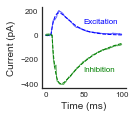

In [26]:
n = {key:value for key,value in neuron}
for numSq in set(n[1]).intersection(set(n[2])):
    for i in set(n[1][numSq].trial).intersection(set(n[2][numSq].trial)):
        if i == 3 and numSq == 7:
            exc = -1e9*n[1][numSq].trial[i].interestWindow
            inh = 1e9*n[2][numSq].trial[i].interestWindow
            time = numpy.arange(len(n[1][numSq].trial[i].interestWindow))*n[1][numSq].trial[i].samplingTime
            exc_fit = fitFunctionToPSP(time, exc)
            inh_fit = fitFunctionToPSP(time, inh)

            fig,ax = plt.subplots() 
            ax.plot(time*1e3, exc, alpha=0.6, c='b')
            ax.set_xlabel("Time (ms)")
            ax.set_ylabel("Current (pA)")
            ax.plot(time*1e3, exc_fit.best_fit, '--', label="Excitation", c='b')

            ax.plot(time*1e3, -inh, alpha=0.6, c='g')
            ax.plot(time*1e3, -inh_fit.best_fit, '--', label="Inhibition", c='g')
            ax.annotate('Excitation', (50,100), (50,100), xycoords='data',color='b')
            ax.annotate('Inhibition', (50,-300), (50,-300), xycoords='data',color='g')
            fig.set_figwidth(1.5)
            fig.set_figheight(1.5)
            simpleaxis(ax)
            dump(fig,file('figures/fig6/6b.pkl','wb'))
            plt.show()

In [5]:
samplingRate = 20  # kHz, to get milliseconds
sample_every = 10 # points
timeStep, maxTime = (sample_every*1.)/ samplingRate, 100.  # ms
trange = numpy.arange(
    0., maxTime, timeStep)  # We will always use 100. ms timecourse of PSPs.

In [6]:
#### Range of $g_e$ explored
emax = 4
e_step = 0.5
erange = numpy.arange(0., emax, e_step)
#### Range of proportionality ($P$) between $E$ and $I$
prop_array = numpy.arange(0, 5, 1)

In [7]:
## Setting up the variables, parameters and units for simulation
t, P, e_r, e_d, delta_e, rho_e, g_e, i_r, i_d, delta_i, rho_i, g_i, b, Cm, g_L = symbols(
    't P \\tau_{er} \\tau_{ed} \\delta_e \\rho_e \\bar{g}_e \\tau_{ir} \\tau_{id} \\delta_i \\rho_i \\bar{g}_i \\beta C_m \\bar{g}_L',
    positive=True,
    real=True)
leak_rev, e_rev, i_rev, Vm = symbols(
    'Leak_{rev} Exc_{rev} Inh_{rev} V_m', real=True)
SymbolDict = {
    t: "Time (ms)",
    P: "Proportion of $g_i/g_e$",
    e_r: "Excitatory Rise (ms)",
    e_d: "Excitatory Fall (ms)",
    delta_e: "Excitatory onset time (ms)",
    rho_e: "Excitatory $tau$ ratio (fall/rise)",
    g_e: "Excitatory max conductance",
    i_r: "Inhibitory Rise (ms)",
    i_d: "Inhibitory Fall(ms)",
    delta_i: "Inhibitory onset time(ms)",
    rho_i: "Inhibitory $tau$ ratio (fall/rise)",
    g_i: "Inhibitory max conductance",
    b: "Inhibitory/Excitatory $tau$ rise ratio"
}
unitsDict = {
    's': seconds,
    'exp': exp,
    'S': siemens,
    'V': volts,
    'A': amperes,
    'm': meters,
    'kg': kg
}  # This is for lamdify
nS, pF, mV, pA = nano * siemens, pico * farads, milli * volts, pico*amperes
### Estimates from data and averaging them to get a number
estimateDict = {
    P: (1.9, 2.1),
    e_r: (1.5 * ms, 5 * ms),
    e_d: (8. * ms, 20. * ms),
    delta_e: (0. * ms, 0. * ms),
    rho_e: (2., 7.),
    g_e: (0.02 * nS, 0.25 * nS),
    i_r: (1.5 * ms, 5. * ms),
    i_d: (14. * ms, 60. * ms),
    delta_i: (2. * ms, 4. * ms),
    rho_i: (5., 20.),
    g_i: (0.04 * nS, 0.5 * nS),
    b: (0.5, 5.)
}
averageEstimateDict = {
    key: value[0] + value[1] / 2
    for key, value in estimateDict.items()
}

### Approximating the rest from literature
approximateDict = {
    g_L: 10 * nS,
    e_rev: 0. * mV,
    i_rev: -70. * mV,
    leak_rev: -65. * mV,
    Cm: 100 * pF
}
sourceDict = {
    g_L: "None",
    e_rev: "None",
    i_rev: "None",
    leak_rev: "None",
    Cm: "Neuroelectro.org"
}

| Variable  |  Meaning |  Range |
|---|---|---|
|$t$|Time (ms)|0-100|
|$P$|Proportion of $g_i/g_e$|2-4|
|$\tau_{er}$|Excitatory Rise (ms)|1.5-5|
|$\tau_{ed}$|Excitatory Fall (ms)|8-20|
|$\delta_e$|Excitatory onset time (ms)|0-0|
|$\rho_e$|Excitatory $tau$ ratio (fall/rise)|2-7|
|$\bar{g}_e$|Excitatory max conductance|0.02-0.25|
|$\tau_{ir}$|Inhibitory Rise (ms)|1.5-5|
|$\tau_{id}$|Inhibitory Fall(ms)|14-60|
|$\delta_i$|Inhibitory onset time(ms)|3-15|
|$\rho_i$|Inhibitory $tau$ ratio (fall/rise)|5-20|
|$\bar{g}_i$|Inhibitory max conductance|0.04-0.5|
|$\beta$|Inhibitory/Excitatory $tau$ rise ratio|0.5-5|

| Variable  |  Meaning | Source | Value |
|---|---|---|
|$g_L$|Leak conductance|Undefined| 10 nS |
|$Exc_{rev}$|Excitatory reversal|Undefined| 0 mV|
|$Inh_{rev}$|Inhibitory reversal |Undefined| -70 mV |
|$Leak_{rev}$|Leak reversal |Undefined| -65 mV |
|$C_m$|Membrane capacitance |neuroelectro.org| 100 pF|

---

In [8]:
### Double exponential to explain the net synaptic conductance.
alpha = exp(-(t - delta_e) / e_d) - exp(-(t - delta_e) / e_r)
alpha_prime = alpha.diff(t)
theta_e = solve(alpha_prime, t)  # Time to peak
theta_e = logcombine(theta_e[0])
simplify(theta_e.subs(averageEstimateDict))
alpha_star = simplify(alpha.subs(t, theta_e).doit())

### Finding maximum of the curve and substituting ratio of taus
g_E = Piecewise((0. * nS, t / ms < delta_e / ms), (g_e * (alpha / alpha_star),
                                                   True))
### Final equation for Excitation normalized to be maximum at $g_e$

### Doing the same with inhibition
g_I = g_E.xreplace({
    g_e: g_i,
    rho_e: rho_i,
    e_r: i_r,
    e_d: i_d,
    delta_e: delta_i
})
alpha_I = alpha.xreplace({e_r: i_r, e_d: i_d, delta_e: delta_i})
alpha_star_I = alpha_star.xreplace({e_r: i_r, e_d: i_d})
g_I = Piecewise((0. * nS, t / ms < delta_i / ms),
                (g_i * (alpha_I / alpha_star_I), True))

In [9]:
### Now finding the control peak using difference of these double-exponentials
compartment = Eq((1 / Cm) * (g_E * (Vm - e_rev) + g_I * (Vm - i_rev) + g_L *
                             (Vm - leak_rev)), Vm.diff(t))
Vm_t = solve(compartment, Vm, rational=False, simplify=True)
check_vm_t = Vm_t[0].subs({ i: averageEstimateDict[i] for i in averageEstimateDict if i not in [g_e, g_i, P] }).subs(approximateDict).subs({ g_i: P * g_e })

In [18]:
f = lambdify((g_e, P, t), check_vm_t/mV, (unitsDict, "numpy"))

In [23]:
check_vm_t

                                                                              
                                                                              
                                                                              
                                                                              
                                                                              
                                                                              
                                                                              
                                                                              
                                                                              
- ────────────────────────────────────────────────────────────────────────────
                                                                              
                                           -0.25⋅t                            
                                         ───────────

In [22]:
f(1* nS, 0, 1* ms)

TypeError: cannot determine truth value of Relational

## 6 C Divisive Inhibition: Inhibition proportional to Excitation, or $g_i = P \times g_e$

In [12]:
di_exc =  [[float(f(e * nS, 0., dt * ms)) for dt in trange] for e in erange]
di_control = {prop: [[float(f(e * nS, prop, dt * ms)) for dt in trange] for e in erange] for prop in prop_array}

TypeError: cannot determine truth value of Relational

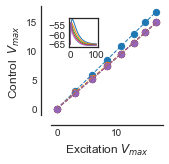

In [23]:
fig, ax = plt.subplots()
# plt.style.context('neuron-color')
handles, labels = [], []
for prop in prop_array:
    v_max, e_max = [], []
    for con_trace,e_t in zip(di_control[prop], di_exc):
        v_max.append(max(con_trace) - float(approximateDict[leak_rev]/mV))
        e_max.append(max(e_t) - float(approximateDict[leak_rev]/mV))
    handles.append(ax.scatter(e_max, v_max, s=40))
    ax.plot(e_max, v_max, '--')
    labels.append("$P= {}$".format(prop))
ax.set_xlabel("Excitation $V_{max}$")
ax.set_ylabel("Control  $V_{max}$")
left, bottom, width, height = [0.25, 0.6, 0.2, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])
for prop in prop_array:
    ax2.plot(trange, di_control[prop][5])
#ax2.set_xlabel("Time")
#ax2.set_ylabel("Membrane potential (mV)")
#fig.legend(handles, labels, loc ='center right')
fig.set_figwidth(2)
fig.set_figheight(2)
simpleaxis(ax)
dump(fig,file('figures/fig6/6c.pkl','wb'))
# ax.set_title("Divisive Inhibition")
plt.show()

In [24]:
print ( "Constant $delta_i$ was {:.1f} ms".format(averageEstimateDict[delta_i]/ms))

Constant $delta_i$ was 4.0 ms


6 DEF: Divisive Normalization: Inhibition proportional to Excitation, or $g_i = P \times g_e$ and $\delta_i$ inversely proportional to $g_e$

## 6 D Changing $\delta_i$ = $\delta_{min} + me^{-k\times{g_e}}$

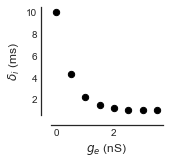

In [25]:
d = lambda minDelay,k,e: minDelay + m*exp(-(k*e))
nS = nano*siemens
k, m, minDelay = 2/nS, 9*ms, 1.*ms
fig, ax = plt.subplots()
ax.scatter(erange, [d(minDelay,k,e*nS)/ms for e in erange], s=40, facecolor='k', edgecolor='k')
ax.set_xlabel("$g_e$ (nS)")
ax.set_ylabel("$\\delta_i$ (ms)")
fig.set_figwidth(2)
fig.set_figheight(2)
simpleaxis(ax)
dump(fig,file('figures/fig6/6d.pkl','wb'))
plt.show()

In [26]:
check_vm = simplify(Vm_t[0].subs({i:averageEstimateDict[i] for i in averageEstimateDict if i not in [g_e, g_i, delta_i]}).subs(approximateDict).subs({g_i: P*g_e, delta_i: d(minDelay,k,g_e)}).evalf())
f = lambdify((g_e, P, t), check_vm/mV, (unitsDict, "numpy"))

In [27]:
dn_exc =  [[float(f(e * nS, 0., dt * ms)) for dt in trange] for e in erange]
dn_control = {prop: [[float(f(e * nS, prop, dt * ms)) for dt in trange] for e in erange] for prop in prop_array}

## 6 E Divisive Normalization 

In [47]:
fig, ax = plt.subplots()
handles, labels = [], []
for prop in prop_array:
    v_max, e_max = [], []
    for con_trace,e_t in zip(dn_control[prop], dn_exc):
        v_max.append(max(con_trace) - float(approximateDict[leak_rev]/mV))
        e_max.append(max(e_t) - float(approximateDict[leak_rev]/mV))
    handles.append(ax.scatter(e_max, v_max, s=40))
    ax.plot(e_max, v_max, '--')
    labels.append("$P= {}$".format(prop))
ax.set_xlabel("Excitation $V_{max}$")
ax.set_ylabel("Control  $V_{max}$")
left, bottom, width, height = [0.25, 0.6, 0.2, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])
for prop in prop_array:
    ax2.plot(trange, dn_control[prop][5])
#ax2.set_xlabel("Time")
#ax2.set_ylabel("Membrane potential (mV)")
# fig.legend(handles, labels, loc ='right')
fig.set_figwidth(2)
fig.set_figheight(2)
simpleaxis(ax)
dump(fig,file('figures/fig6/6e.pkl','wb'))
# ax.set_title("Divisive Normalization", fontsize=18)
plt.show()

KeyError: 0.10000000000000001

## 5 B Model subtraction scheme

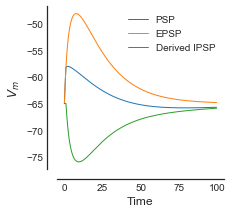

In [29]:
fig, ax = plt.subplots()
handles, labels = [], []
prop = 4

i_max, e_max = [], []
trace_c, trace_e = numpy.array(dn_control[prop][-1]), numpy.array(dn_exc[-1])
ax.plot(trange, trace_c, label="PSP")
ax.plot(trange, trace_e, label="EPSP")
trace_i =  float(approximateDict[leak_rev]/mV) + (trace_c - trace_e)
ax.plot(trange, trace_i, label="Derived IPSP")
ax.set_xlabel("Time")
ax.set_ylabel("$V_m$")
fig.set_figwidth(3)
fig.set_figheight(3)
simpleaxis(ax)
dump(fig,file('figures/fig5/5b.pkl','wb'))
plt.legend()
plt.show()

## 6 F Excitation - Derived Inhibition plot

In [48]:
fig, ax = plt.subplots()
handles, labels = [], []
for prop in prop_array:
    i_max, e_max = [], []
    for con_trace,e_t in zip(dn_control[prop], dn_exc):
        i_max.append(max(e_t) - max(con_trace))
        e_max.append(max(e_t) - float(approximateDict[leak_rev]/mV))
    handles.append(ax.scatter(e_max, i_max, s=40))
    ax.plot(e_max, i_max, '--')
    labels.append("$P= {}$".format(prop))
ax.set_xlabel("Excitation $V_{max}$")
ax.set_ylabel("Derived Inhibition  $V_{max}$")
xlim = ax.get_xlim()
ax.set_ylim (xlim)
ax.plot(xlim, xlim, '--')
# fig.legend(handles, labels, loc ='center right')
fig.set_figwidth(2)
fig.set_figheight(2)
simpleaxis(ax)
dump(fig,file('figures/fig6/6f.pkl','wb'))
plt.show()

KeyError: 0.10000000000000001

## 6 G Time to peak

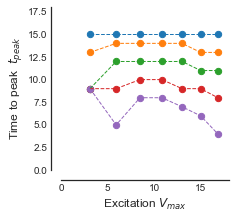

In [31]:
fig, ax = plt.subplots()
handles, labels = [], []
for prop in prop_array:
    ttp, e_max = [], []
    for con_trace,e_t in zip(dn_control[prop], dn_exc):
        ttp.append(numpy.argmax(con_trace))
        e_max.append(max(e_t) - float(approximateDict[leak_rev]/mV))
    handles.append(ax.scatter(e_max[1:], ttp[1:], s=40))
    ax.plot(e_max[1:], ttp[1:], '--')
    labels.append("$P= {}$".format(prop))
ax.set_xlabel("Excitation $V_{max}$")
ax.set_ylabel("Time to peak  $t_{peak}$")
ax.set_xlim(0,18)
ax.set_ylim(0,18)
# fig.legend(handles, labels, loc ='center right')
fig.set_figwidth(3)
fig.set_figheight(3)
simpleaxis(ax)
dump(fig,file('figures/fig6/6g.pkl','wb'))
plt.show()

## 6 H Permutation of P

In [32]:
check_vm = simplify(Vm_t[0].subs({i:averageEstimateDict[i] for i in averageEstimateDict if i not in [g_e, g_i, delta_i]}).subs(approximateDict).subs({delta_i: d(minDelay,k,g_e)}).evalf())
f = lambdify((g_e, g_i, t), check_vm/mV, (unitsDict, "numpy"))

In [33]:
p_perm_dn_exc =  [[float(f(e * nS, 0., dt * ms)) for dt in trange] for e in erange]
p_perm_dn_control = {prop: [[float(f(e * nS, i * nS, dt * ms)) for dt in trange] for (e,i) in zip(erange, numpy.random.permutation(erange*prop))] for prop in prop_array}

In [49]:
fig, ax = plt.subplots()
handles, labels = [], []
for prop in prop_array:
    v_max, e_max = [], []
    for con_trace,e_t in zip(p_perm_dn_control[prop], p_perm_dn_exc):
        v_max.append(max(con_trace) - float(approximateDict[leak_rev]/mV))
        e_max.append(max(e_t) - float(approximateDict[leak_rev]/mV))
    handles.append(ax.scatter(e_max, v_max, s=40))
    ax.plot(e_max, v_max, '--')
    labels.append("$P= {}$".format(prop))
ax.set_xlabel("Excitation $V_{max}$")
ax.set_ylabel("Control  $V_{max}$")
left, bottom, width, height = [0.25, 0.6, 0.2, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])
for prop in prop_array:
    ax2.plot(trange, p_perm_dn_control[prop][5])
#ax2.set_xlabel("Time")
#ax2.set_ylabel("Membrane potential (mV)")
# fig.legend(handles, labels, loc ='center right')
fig.set_figwidth(3)
fig.set_figheight(3)
simpleaxis(ax)
dump(fig,file('figures/fig6/6h.pkl','wb'))
# ax.set_title("Divisive Normalization with E and I balance permuted", fontsize=18)
plt.show()

KeyError: 0.10000000000000001

## 6 I Permutation of $\delta_i$

In [35]:
check_vm = simplify(Vm_t[0].subs({i:averageEstimateDict[i] for i in averageEstimateDict if i not in [g_e, g_i, delta_i]}).subs(approximateDict).subs({g_i: P*g_e}).evalf())
f = lambdify((g_e, P, delta_i, t), check_vm/mV, (unitsDict, "numpy"))

In [36]:
d_perm_dn_exc =  [[float(f(e * nS, 0., d(minDelay,k, e* nS), dt * ms)) for dt in trange] for e in erange]
d_perm_dn_control = {prop: [[float(f(e * nS, prop, delay, dt * ms)) for dt in trange] for e,delay in zip(erange, numpy.random.permutation([d(minDelay,k, e* nS) for e in erange])) ] for prop in prop_array}

In [50]:
fig, ax = plt.subplots()
handles, labels = [], []
for prop in prop_array:
    v_max, e_max = [], []
    for con_trace,e_t in zip(d_perm_dn_control[prop], d_perm_dn_exc):
        v_max.append(max(con_trace) - float(approximateDict[leak_rev]/mV))
        e_max.append(max(e_t) - float(approximateDict[leak_rev]/mV))
    handles.append(ax.scatter(e_max, v_max, s=40))
    ax.plot(e_max, v_max, '--')
    labels.append("$P= {}$".format(prop))
ax.set_xlabel("Excitation $V_{max}$")
ax.set_ylabel("Control  $V_{max}$")
left, bottom, width, height = [0.25, 0.6, 0.2, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])
for prop in prop_array:
    ax2.plot(trange, d_perm_dn_control[prop][5])
# fig.legend(handles, labels, loc ='center right')
fig.set_figwidth(2)
fig.set_figheight(2)
simpleaxis(ax)
dump(fig,file('figures/fig6/6i.pkl','wb'))
# ax.set_title("Divisive Normalization", fontsize=18)
plt.show()

KeyError: 0.10000000000000001

## 6 J Phase plot Divisive Normalization

In [38]:
import lmfit
def DN_model(x,a=1):
    # Divisive normalization model
    #return x - a*(x**2)/(b+x)
    return x/(a*x+1)
DN_Model = lmfit.Model(DN_model)

In [39]:
check_vm = simplify(Vm_t[0].subs({i:averageEstimateDict[i] for i in averageEstimateDict if i not in [g_e, g_i, delta_i]}).subs(approximateDict).subs({g_i: P*g_e}).evalf())
f = lambdify((g_e, P, delta_i, t), check_vm/mV, (unitsDict, "numpy"))

In [40]:
phase_dn_control = {}
phase_dn_exc = {}
prop_array = numpy.logspace(-1,1,7)
k_array = numpy.logspace(-1,1,7)
for k in k_array:
    phase_dn_exc[k] = [[float(f(e * nS, 0., d(minDelay,k/nS, e* nS), dt * ms)) for dt in trange] for e in erange]
    phase_dn_control[k] = {prop: [[float(f(e * nS, prop, delay, dt * ms)) for dt in trange] for e,delay in zip(erange, [d(minDelay,k/nS, e* nS) for e in erange]) ] for prop in prop_array}

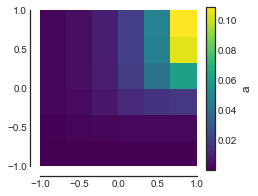

In [41]:
fig, ax = plt.subplots()
phaseMat = numpy.zeros((len(k_array),len(prop_array)))
for ind1, k in enumerate(k_array):
    for ind2, prop in enumerate(prop_array):
        v_max, e_max = [], []
        for con_trace,e_t in zip(phase_dn_control[k][prop], phase_dn_exc[k]):
            v_max.append(max(con_trace) - float(approximateDict[leak_rev]/mV))
            e_max.append(max(e_t) - float(approximateDict[leak_rev]/mV))
        X, y = e_max, v_max
        DN_pars = DN_Model.make_params()
        DN_result = DN_Model.fit(y, DN_pars, x=X)
        phaseMat[ind1][ind2] = DN_result.params['a']
#         print(DN_result.fit_report())

x,y = numpy.meshgrid(numpy.linspace(-1,1,7),numpy.linspace(-1,1,7))
heatmap = ax.pcolor(x,y, phaseMat, cmap =matplotlib.cm.viridis)

# ax.xaxis.set(ticklabels=[str(j) for j in k_array])
# ax.yaxis.set(ticklabels=[str(j) for j in prop_array])

# ax.axis([int(k_array.min()),int(k_array.max()),int(prop_array.min()),int(prop_array.max())])

# ax.set_xlabel("K", fontsize=14)
# ax.set_ylabel("P", fontsize=14)
# ax.set_title("Divisive Normalization", fontsize=18)
plt.colorbar(heatmap, label = "a")
ax.set_aspect(1)
fig.set_figwidth(3.5)
fig.set_figheight(3)
simpleaxis(ax)
dump(fig,file('figures/fig6/6j.pkl','wb'))
plt.show()

In [42]:
# for ind1, k in enumerate(k_array):
#     for ind2, prop in enumerate(prop_array):
#         v_max, e_max = [], []
#         for con_trace,e_t in zip(phase_dn_control[k][prop], phase_dn_exc[k]):
#             v_max.append(max(con_trace) - float(approximateDict[leak_rev]/mV))
#             e_max.append(max(e_t) - float(approximateDict[leak_rev]/mV))
#         X, y = e_max, v_max
#         DN_pars = DN_Model.make_params()
#         DN_result = DN_Model.fit(y, DN_pars, x=X)
#         print (k, prop)
#         print(DN_result.fit_report())
#         f,ax = plt.subplots()
#         DN_result.plot_fit(ax)
#         plt.show()

## 6 K $\delta_i$ as a function of $g_e$

In [43]:
n = Neuron.load('/media/sahil/NCBS_Shares_BGStim/patch_data/161220/c2_EI/plots/c2_EI.pkl')

/media/sahil/NCBS_Shares_BGStim/patch_data/161220/c2_EI/plots/c2_EI.pkl not found.


In [44]:
def delay_excitation(x, a=1, b=1, c=1):
    # Delay as a function of excitation
    return a + b*numpy.exp(-c*x)

In [45]:
def findOnsetTime(trial, step=.25, slide = 0.05, minOnset = 2., maxOnset = 50., initpValTolerance=1.0, pValMinTolerance = 0.05):
    maxIndex = int(trial.F_sample*maxOnset*1e-3)
    if expType == 1:
        maxOnsetIndex = numpy.argmax(-trial.interestWindow[:maxIndex])
    elif expType == 2:
        maxOnsetIndex = numpy.argmax(trial.interestWindow[:maxIndex])
    else:
        maxOnsetIndex = numpy.argmax(trial.interestWindow[:maxIndex])
    
    window_size = len(trial.interestWindow)
    step_size = int(trial.F_sample*step*1e-3)
    
    overlap =  int(trial.F_sample*slide*1e-3)
    
    index_right = maxOnsetIndex
    index_left = index_right - step_size
    minOnsetIndex = int(trial.F_sample*minOnset*1e-3)
    
    baseMean = numpy.mean(trial.interestWindow[:minOnsetIndex])
    factor = 5
    thresholdGradient = 0.01
    pValTolerance = initpValTolerance

    l_window = trial.interestWindow[:minOnsetIndex]
    while (index_left>minOnset):
        r_window = trial.interestWindow[index_left:index_right] #, trial.baselineWindow #trial.interestWindow[index_left - step_size:index_left]
        stat, pVal = ss.ks_2samp(r_window, l_window)
        if pVal>pValTolerance:
            return float(index_right)/trial.F_sample

        else:
            index_left-=overlap
            index_right-=overlap
            if index_left<=minOnsetIndex:
                pValTolerance/=2
                if pValTolerance<pValMinTolerance:
#                             print ("Returning Nan")
                            return numpy.nan
                else:
                    index_right = maxOnsetIndex
                    index_left = maxOnsetIndex - step_size

In [46]:
avg_exc_onset = {}
avg_inh_onset = {}
avg_exc_max = {}
exc_onsets, inh_onsets = {}, {}
exc_max,inh_max = {}, {}
err_inh_onsets = {}
for expType, exp in n:
    for sqr in exp:
        for coord in exp[sqr].coordwise:
            if expType == 1:
                for trial in exp[sqr].coordwise[coord].trials:
                    exc_onsets[(sqr,trial.index)] = findOnsetTime(trial)*1e3
                    exc_max[(sqr,trial.index)] = -trial.feature[5]*1e6
                    #exp[sqr].coordwise[coord].average_feature[5]
            if expType == 2:
                list_inh_onset = []
                for trial in exp[sqr].coordwise[coord].trials:
                    inh_onsets[(sqr,trial.index)] = findOnsetTime(trial)*1e3
                    list_inh_onset.append(inh_onsets[(sqr,trial.index)])
                    inh_max[(sqr,trial.index)] = trial.feature[0]*1e6
                avg_onset = numpy.nanmean([onset for onset in list_inh_onset if onset])
                err_onset = numpy.nanstd([onset for onset in list_inh_onset if onset])
                for trial in exp[sqr].coordwise[coord].trials:
                    avg_inh_onset[(sqr,trial.index)] = avg_onset
                    err_inh_onsets[(sqr,trial.index)] = err_onset
#print (avg_exc_max, avg_exc_onset, avg_inh_onset)

TypeError: 'NoneType' object is not iterable

In [ ]:
delay, max_current = [], []
del_err, max_err= [], []
inhibOnset = []
for key in set(exc_onsets).intersection(set(avg_inh_onset)):
    if avg_inh_onset[key] and exc_onsets[key]:
        if not numpy.isnan(avg_inh_onset[key]) and not numpy.isnan (exc_onsets[key]) and not numpy.isnan (exc_max[key]):
            delay.append(avg_inh_onset[key]- exc_onsets[key])
            max_current.append(exc_max[key])
            del_err.append(err_inh_onsets[key])
            inhibOnset.append(inh_onsets[key])
#         del_err.append()
#         max_err.append()

In [ ]:
delay_Model = lmfit.Model(delay_excitation)
delay_pars = delay_Model.make_params()

delay = numpy.array(delay)
max_current = numpy.array(max_current)

delay_result = delay_Model.fit(delay, delay_pars, x=max_current)
# print (delay_result.params)
# print (delay_result.aic)
# print (delay_result.redchi)

In [ ]:
fig, ax = plt.subplots()
ax.errorbar(numpy.array(max_current), numpy.array(delay), fmt ='o', yerr=numpy.array(del_err), markersize=2, alpha=0.4)
#ax.scatter(numpy.array(max_current)*1e6, numpy.array(delay)*1e3)
current_linspace= numpy.linspace(0,1.1*numpy.max(max_current))
ax.plot(current_linspace, delay_result.eval(x=current_linspace), '-', label="${:.2f} + {:.2f} \\times e^{{-{:.2f} \\times E }}$".format(delay_result.params['a'].value, delay_result.params['b'].value, delay_result.params['c'].value))

ax.plot(1./(delay_result.params['c'].value), delay_result.eval(x=1./(delay_result.params['c'].value)), 'ko', markersize=2)
xmin, xmax = ax.get_xlim()
ax.hlines(y=0, xmin=xmin, xmax=xmax, linestyles='--', alpha=0.5)
ax.hlines(y=delay_result.params['a'].value, xmin=xmin, xmax=xmax, linestyles='--', alpha=0.5)
ax.set_xlabel("$I_{max}^{exc}$")
ax.set_ylabel("Delay $(\\delta_{inh})$")

ax.annotate("",
            xy=(xmax, 0.), xycoords='data',
            xytext=(xmax, delay_result.params['a'].value), textcoords='data',
            arrowprops=dict(arrowstyle="<->",
                            connectionstyle="arc3"),
            )
ax.text(1.01*xmax, 1., "$\\delta_{min}$")

ax.annotate("",
            xy=(0, 0), xycoords='data',
            xytext=(0, delay_result.params['b'].value + delay_result.params['a'].value), textcoords='data',
            arrowprops=dict(arrowstyle="<->",
                            connectionstyle="arc3"),
            )
ax.text(xmin*1.5, 10., "$\\delta_{max}$")

ax.annotate("",
            xy=(xmax, delay_result.params['a'].value), xycoords='data',
            xytext=(xmax,  delay_result.params['b'].value + delay_result.params['a'].value), textcoords='data',
            arrowprops=dict(arrowstyle="<->",
                            connectionstyle="arc3"),
            )
ax.text(1.01*xmax, 10., "$m$")

# ax.text(0.006, 6., "$k$")
ax.set_xlim(xmax= xmax*1.1)
simpleaxis(ax)
plt.legend()
fig.set_figwidth(6)
fig.set_figheight(6)
dump(fig,file('figures/fig6/6k.pkl','wb'))
plt.show()